In [ ]:
!pip install tensorflow


**What this notebook does:**

* Builds a clean MLP (Keras/TensorFlow) for a classification task.
* Demonstrates how to tune: number of layers / units, learning rate, batch size, dropout.
* Uses EarlyStopping and saves training histories.
* Produces validation curves (train vs val loss & accuracy) and a summary table of experiments.

---

## 1. Enable GPU in Colab

In Colab set Runtime → Change runtime type → GPU. Not required but speeds training.

---

## 2. Imports & helper functions


In [1]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [2]:
# ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Dataset & preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 3. Create synthetic dataset (easy to run anywhere)

In [5]:
# Binary classification synthetic dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=10,
                           n_redundant=2, n_repeated=0, n_classes=2,
                           class_sep=1.0, flip_y=0.01, random_state=42)


make_classification() generates a fully artificial synthetic dataset for classification tasks.

It returns:

X → shape (10000, 20)
A NumPy array with 20 numerical features for each sample

y → shape (10000,)
The class label (0 or 1)

**n_features = 20**

Each sample has 20 input features
→ like 20 columns.

**n_informative = 10**

Out of the 20 features:

10 features truly affect the class label
These are meaningful patterns.

**n_redundant = 2**

These features are linear combinations of the informative ones.
They don’t add new info; they just copy the patterns.


**n_repeated = 0**

No duplicated columns.

**n_classes = 2**

Binary classification (label is 0 or 1)

**class_sep = 1.0**

Controls how far apart class 0 and class 1 are
• Higher → easier classification
• Lower → overlapping classes (harder)

**flip_y = 0.01**

Add 1% random label noise (to simulate real-world imperfect labels).

**random_state = 42**

Ensures SAME random data every run (for reproducibility).

In [6]:
import pandas as pd

df = pd.DataFrame(X)
df['label'] = y

df.head()


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,1.145527,-1.431231,1.343553,-2.226251,2.836266,0.393725,0.497039,-2.679342,-0.484000,0.543561,...,-3.385892,1.383486,0.848493,-2.740663,0.032651,-1.854549,-3.469541,1.938754,-1.602788,1
1,-0.398627,-4.021327,0.303138,1.891864,-1.176440,-0.494744,2.242590,4.944493,3.005969,0.696579,...,-1.516941,0.081452,-3.955249,-3.488351,3.537090,3.070008,2.241036,-2.255867,0.882113,0
2,1.373291,-0.178694,-1.590718,3.107308,0.980686,0.828572,-0.524063,0.439533,1.717222,0.720226,...,-3.646519,0.468561,-2.909754,-3.210179,-0.656369,1.337481,0.687274,-1.598358,0.365950,1
3,-0.334228,1.811195,2.606076,2.305094,-0.093021,-0.619862,1.070445,-0.912655,-2.038940,-1.243452,...,-0.877006,-1.317697,-0.485025,-1.100836,-2.959932,-0.203805,-0.222513,-0.947643,-0.275123,1
4,1.371725,-4.808889,1.564857,5.449681,-1.988532,-1.030014,0.019262,5.393165,0.067129,-1.160891,...,-0.049544,0.627094,-3.405261,0.025678,3.169422,-1.188827,-0.005081,-3.915832,-1.398771,0


In [7]:
# Train / val / test split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

In [8]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print('Shapes:', X_train.shape, X_val.shape, X_test.shape)

Shapes: (7000, 20) (1500, 20) (1500, 20)


Normalizes (standardizes) the input features so that all features have:

mean = 0

standard deviation = 1

This is called Z-score normalization.

Why do we need to scale data?

Neural networks train better when all input features are on a similar scale.

## 4. Model builder: parametric MLP


Defines how many input features the model will receive.

Creates multiple Dense Hidden layers.

Adds dropout after each layer if dropout_rate > 0

Outputs a single value between 0 and 1.

**model = keras.Model(inputs, outputs)** Connects all layers into one model.




**model.compile()** Compile the model

Uses the Adam optimizer with your chosen learning rate.

Loss function = binary_crossentropy (because it's binary classification).

Tracks accuracy during training.

In [9]:
def build_mlp(input_shape, layer_units=(64, 32), dropout_rate=0.0, lr=1e-3):
    inputs = keras.Input(shape=(input_shape,))
    x = inputs
    for i, units in enumerate(layer_units):
        x = layers.Dense(units, activation='relu', name=f'dense_{i+1}')(x)
        if dropout_rate and dropout_rate>0:
            x = layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
    outputs = layers.Dense(1, activation='sigmoid', name='out')(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## 5. Plotting learning curves helper

In [10]:
def plot_history(history, title=None):
    # history: `keras.callbacks.History` or dict-like with 'loss','val_loss','accuracy','val_accuracy'
    if isinstance(history, dict):
        h = history
    else:
        h = history.history
    epochs = range(1, len(h['loss'])+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train loss')
    plt.plot(epochs, h['val_loss'], label='val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, h.get('accuracy', h.get('acc', [])), label='train acc')
    plt.plot(epochs, h.get('val_accuracy', h.get('val_acc', [])), label='val acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend()

    if title:
        plt.suptitle(title)
    plt.show()

## 6. Tuning Different Parameters

## **model=build_mlp()** then **model.fit()** then **model.evaluate()**

# Tune layer_units


layer_units decides how many neurons are in each hidden layer.
Example: (128, 64) means the model has two hidden layers:
- first layer with 128 neurons
- second layer with 64 neurons.



Training with layer_units = (64,)
Epoch 1/50
55/55 - 1s - 18ms/step - accuracy: 0.6690 - loss: 0.6135 - val_accuracy: 0.7673 - val_loss: 0.5082
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.8041 - loss: 0.4508 - val_accuracy: 0.8107 - val_loss: 0.4217
Epoch 3/50
55/55 - 0s - 2ms/step - accuracy: 0.8340 - loss: 0.3873 - val_accuracy: 0.8320 - val_loss: 0.3783
Epoch 4/50
55/55 - 0s - 2ms/step - accuracy: 0.8529 - loss: 0.3514 - val_accuracy: 0.8473 - val_loss: 0.3521
Epoch 5/50
55/55 - 0s - 2ms/step - accuracy: 0.8579 - loss: 0.3298 - val_accuracy: 0.8553 - val_loss: 0.3335
Epoch 6/50
55/55 - 0s - 2ms/step - accuracy: 0.8631 - loss: 0.3160 - val_accuracy: 0.8653 - val_loss: 0.3178
Epoch 7/50
55/55 - 0s - 2ms/step - accuracy: 0.8729 - loss: 0.2988 - val_accuracy: 0.8713 - val_loss: 0.3047
Epoch 8/50
55/55 - 0s - 2ms/step - accuracy: 0.8769 - loss: 0.2862 - val_accuracy: 0.8727 - val_loss: 0.2934
Epoch 9/50
55/55 - 0s - 2ms/step - accuracy: 0.8841 - loss: 0.2753 - val_accuracy: 0.8793 - 

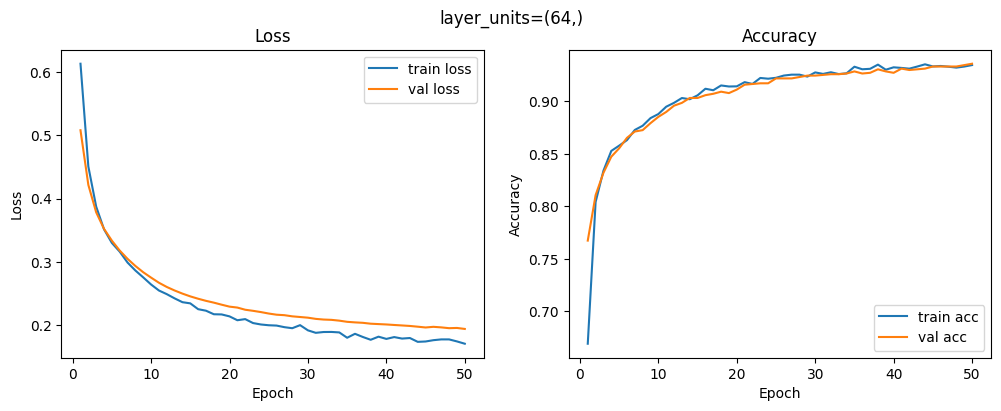


Training with layer_units = (128, 64)
Epoch 1/50
55/55 - 1s - 22ms/step - accuracy: 0.7653 - loss: 0.4943 - val_accuracy: 0.8347 - val_loss: 0.3779
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.8406 - loss: 0.3534 - val_accuracy: 0.8680 - val_loss: 0.3163
Epoch 3/50
55/55 - 0s - 3ms/step - accuracy: 0.8649 - loss: 0.3094 - val_accuracy: 0.8880 - val_loss: 0.2789
Epoch 4/50
55/55 - 0s - 3ms/step - accuracy: 0.8829 - loss: 0.2724 - val_accuracy: 0.9007 - val_loss: 0.2548
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.8937 - loss: 0.2529 - val_accuracy: 0.9067 - val_loss: 0.2389
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.9014 - loss: 0.2363 - val_accuracy: 0.9160 - val_loss: 0.2266
Epoch 7/50
55/55 - 0s - 3ms/step - accuracy: 0.9073 - loss: 0.2216 - val_accuracy: 0.9153 - val_loss: 0.2208
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9133 - loss: 0.2145 - val_accuracy: 0.9207 - val_loss: 0.2142
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.9187 - loss: 0.2045 - val_accuracy: 0.924

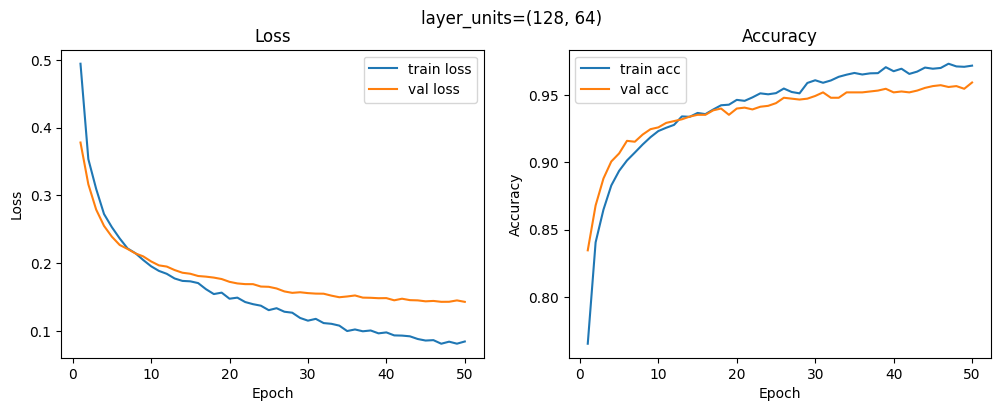

In [11]:
layer_options = [(64,), (128,64)]

for units in layer_options:
    print("\nTraining with layer_units =", units)

    model = build_mlp(
        input_shape=X_train.shape[1],
        layer_units=units,
        dropout_rate=0.2,   # fixed
        lr=1e-3,            # fixed
        )

    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6,
        restore_best_weights=True, verbose=1
    )

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        callbacks=[es],
        verbose=2
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", test_loss, "Test Acc:", test_acc)

    plot_history(hist, title=f"layer_units={units}")


The (128, 64) architecture performs better.

It has lower validation loss (~0.13 vs ~0.19).

And higher validation accuracy (~0.965 vs ~0.945).

 The curves are smooth with no major
overfitting. Therefore, (128, 64) is the better choice.


In [12]:
best_layer_units = (128,64)   # <-- you update this


# Tune dropout_rate


Training with dropout_rate = 0.0


Epoch 1/50
55/55 - 1s - 16ms/step - accuracy: 0.7924 - loss: 0.4594 - val_accuracy: 0.8473 - val_loss: 0.3390
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.8694 - loss: 0.2971 - val_accuracy: 0.8787 - val_loss: 0.2859
Epoch 3/50
55/55 - 0s - 2ms/step - accuracy: 0.8944 - loss: 0.2501 - val_accuracy: 0.8953 - val_loss: 0.2561
Epoch 4/50
55/55 - 0s - 2ms/step - accuracy: 0.9090 - loss: 0.2202 - val_accuracy: 0.9000 - val_loss: 0.2377
Epoch 5/50
55/55 - 0s - 2ms/step - accuracy: 0.9190 - loss: 0.1997 - val_accuracy: 0.9100 - val_loss: 0.2261
Epoch 6/50
55/55 - 0s - 2ms/step - accuracy: 0.9280 - loss: 0.1851 - val_accuracy: 0.9107 - val_loss: 0.2185
Epoch 7/50
55/55 - 0s - 2ms/step - accuracy: 0.9340 - loss: 0.1736 - val_accuracy: 0.9173 - val_loss: 0.2133
Epoch 8/50
55/55 - 0s - 2ms/step - accuracy: 0.9394 - loss: 0.1645 - val_accuracy: 0.9233 - val_loss: 0.2095
Epoch 9/50
55/55 - 0s - 2ms/step - accuracy: 0.9437 - loss: 0.1568 - val_accuracy: 0.9253 - val_loss: 0.2064
Epoch 10/50
55/55 

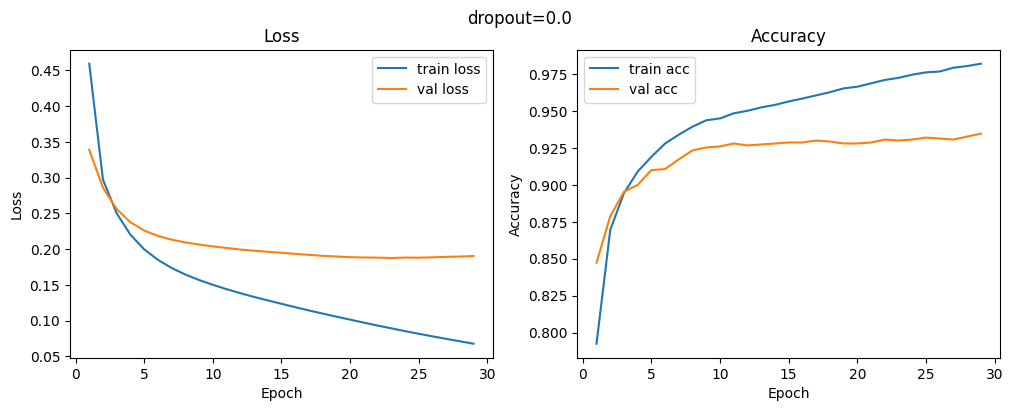


Training with dropout_rate = 0.25
Epoch 1/50
55/55 - 1s - 16ms/step - accuracy: 0.7321 - loss: 0.5151 - val_accuracy: 0.8333 - val_loss: 0.3749
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.8407 - loss: 0.3483 - val_accuracy: 0.8660 - val_loss: 0.3101
Epoch 3/50
55/55 - 0s - 3ms/step - accuracy: 0.8691 - loss: 0.3005 - val_accuracy: 0.8847 - val_loss: 0.2763
Epoch 4/50
55/55 - 0s - 3ms/step - accuracy: 0.8801 - loss: 0.2760 - val_accuracy: 0.8980 - val_loss: 0.2579
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.8949 - loss: 0.2537 - val_accuracy: 0.9060 - val_loss: 0.2437
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.9026 - loss: 0.2417 - val_accuracy: 0.9153 - val_loss: 0.2350
Epoch 7/50
55/55 - 0s - 3ms/step - accuracy: 0.9033 - loss: 0.2363 - val_accuracy: 0.9153 - val_loss: 0.2295
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9113 - loss: 0.2224 - val_accuracy: 0.9213 - val_loss: 0.2219
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.9147 - loss: 0.2140 - val_accuracy: 0.9247 - 

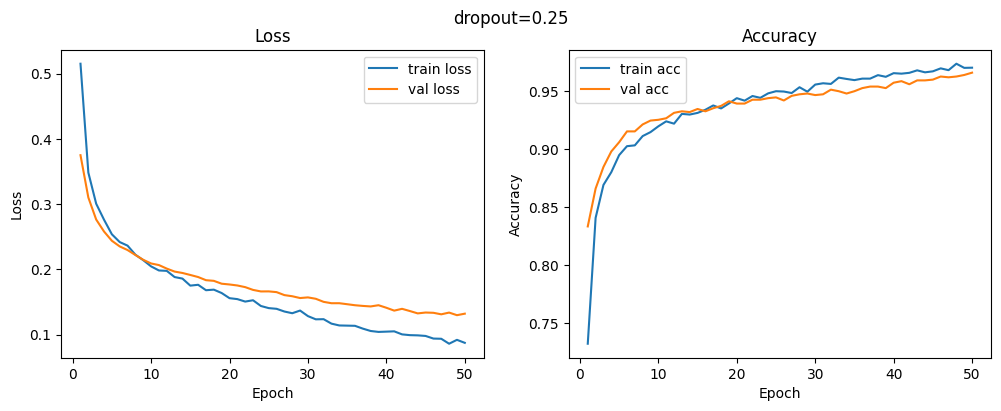


Training with dropout_rate = 0.5
Epoch 1/50
55/55 - 1s - 16ms/step - accuracy: 0.6871 - loss: 0.5785 - val_accuracy: 0.8167 - val_loss: 0.4263
Epoch 2/50
55/55 - 0s - 2ms/step - accuracy: 0.7954 - loss: 0.4273 - val_accuracy: 0.8473 - val_loss: 0.3584
Epoch 3/50
55/55 - 0s - 2ms/step - accuracy: 0.8284 - loss: 0.3805 - val_accuracy: 0.8593 - val_loss: 0.3285
Epoch 4/50
55/55 - 0s - 2ms/step - accuracy: 0.8461 - loss: 0.3486 - val_accuracy: 0.8747 - val_loss: 0.3072
Epoch 5/50
55/55 - 0s - 2ms/step - accuracy: 0.8543 - loss: 0.3293 - val_accuracy: 0.8827 - val_loss: 0.2921
Epoch 6/50
55/55 - 0s - 2ms/step - accuracy: 0.8677 - loss: 0.3084 - val_accuracy: 0.8920 - val_loss: 0.2773
Epoch 7/50
55/55 - 0s - 2ms/step - accuracy: 0.8754 - loss: 0.2958 - val_accuracy: 0.9013 - val_loss: 0.2655
Epoch 8/50
55/55 - 0s - 2ms/step - accuracy: 0.8813 - loss: 0.2807 - val_accuracy: 0.9027 - val_loss: 0.2538
Epoch 9/50
55/55 - 0s - 2ms/step - accuracy: 0.8859 - loss: 0.2751 - val_accuracy: 0.9087 - v

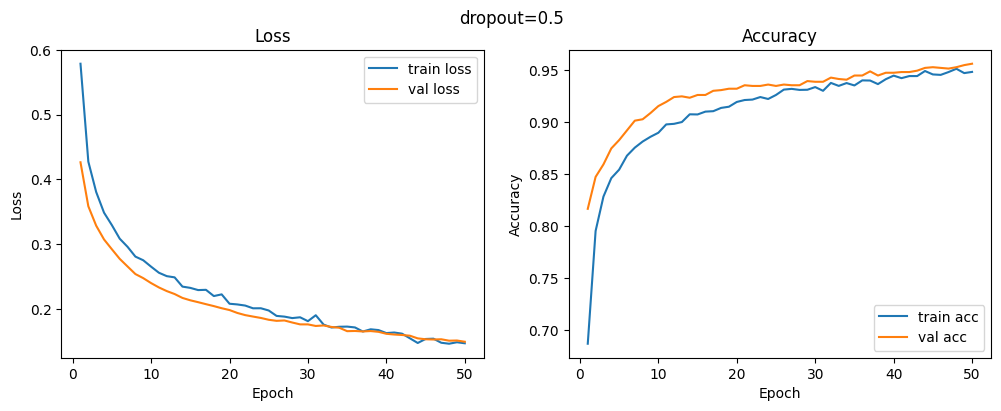

In [13]:
drop_options = [0.0, 0.25,0.5]

for d in drop_options:
    print("\nTraining with dropout_rate =", d)

    model = build_mlp(
        input_shape=X_train.shape[1],
        layer_units=best_layer_units,
        dropout_rate=d,
        lr=1e-3
    )

    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6,
        restore_best_weights=True, verbose=1
    )

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        callbacks=[es],
        verbose=2
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", test_loss, "Test Acc:", test_acc)

    plot_history(hist, title=f"dropout={d}")


Patience: Wait for 6 epochs after the last improvement before stopping.

Dropout = 0.25 is the best choice because it gives the lowest validation loss, the highest validation accuracy, and shows no signs of overfitting.

Dropout=0.0 overfits slightly, while dropout=0.5 underfits the model.


In [14]:
best_dropout = 0.25

# Tune learning rate


Training with lr = 0.001
Epoch 1/50
55/55 - 1s - 17ms/step - accuracy: 0.7629 - loss: 0.4880 - val_accuracy: 0.8347 - val_loss: 0.3757
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.8420 - loss: 0.3563 - val_accuracy: 0.8613 - val_loss: 0.3208
Epoch 3/50
55/55 - 0s - 3ms/step - accuracy: 0.8647 - loss: 0.3056 - val_accuracy: 0.8840 - val_loss: 0.2858
Epoch 4/50
55/55 - 0s - 3ms/step - accuracy: 0.8823 - loss: 0.2812 - val_accuracy: 0.8933 - val_loss: 0.2620
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.8911 - loss: 0.2564 - val_accuracy: 0.9080 - val_loss: 0.2455
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.8986 - loss: 0.2454 - val_accuracy: 0.9173 - val_loss: 0.2337
Epoch 7/50
55/55 - 0s - 3ms/step - accuracy: 0.9007 - loss: 0.2342 - val_accuracy: 0.9213 - val_loss: 0.2265
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9140 - loss: 0.2162 - val_accuracy: 0.9267 - val_loss: 0.2164
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.9190 - loss: 0.2075 - val_accuracy: 0.9273 - val_loss:

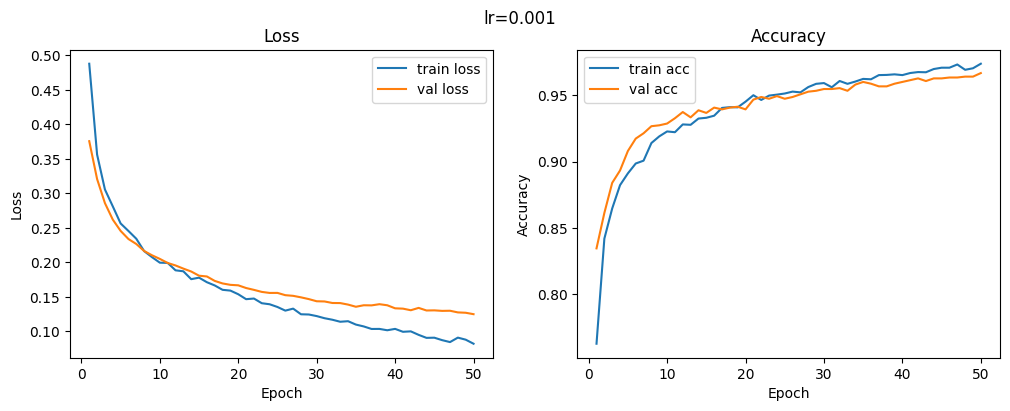


Training with lr = 0.005
Epoch 1/50
55/55 - 1s - 21ms/step - accuracy: 0.8260 - loss: 0.3758 - val_accuracy: 0.8953 - val_loss: 0.2789
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.8979 - loss: 0.2532 - val_accuracy: 0.9193 - val_loss: 0.2337
Epoch 3/50
55/55 - 0s - 3ms/step - accuracy: 0.9197 - loss: 0.2120 - val_accuracy: 0.9327 - val_loss: 0.2058
Epoch 4/50
55/55 - 0s - 3ms/step - accuracy: 0.9276 - loss: 0.1949 - val_accuracy: 0.9327 - val_loss: 0.1941
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.9403 - loss: 0.1679 - val_accuracy: 0.9413 - val_loss: 0.1765
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.9430 - loss: 0.1545 - val_accuracy: 0.9467 - val_loss: 0.1736
Epoch 7/50
55/55 - 0s - 2ms/step - accuracy: 0.9487 - loss: 0.1470 - val_accuracy: 0.9480 - val_loss: 0.1695
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9494 - loss: 0.1363 - val_accuracy: 0.9527 - val_loss: 0.1616
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.9533 - loss: 0.1326 - val_accuracy: 0.9567 - val_loss:

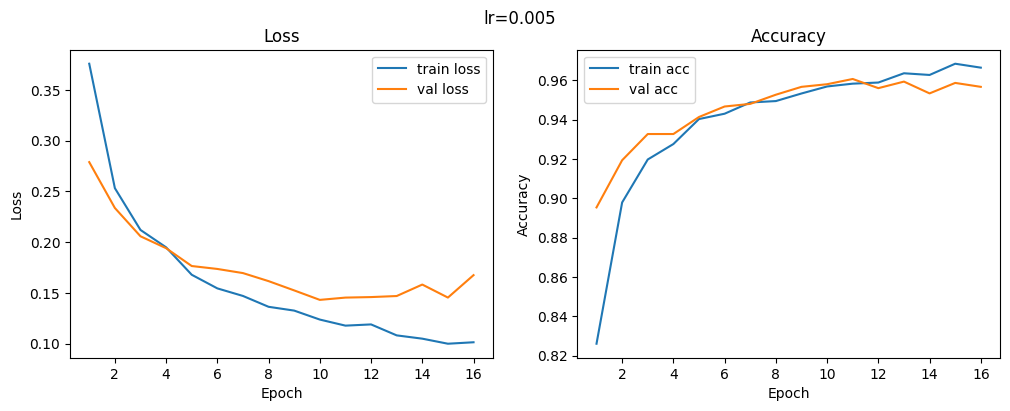

In [15]:
lr_options = [1e-3, 5e-3]

for lr in lr_options:
    print("\nTraining with lr =", lr)

    model = build_mlp(
        input_shape=X_train.shape[1],
        layer_units=best_layer_units,
        dropout_rate=best_dropout,
        lr=lr
    )

    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6,
        restore_best_weights=True, verbose=1
    )

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        callbacks=[es],
        verbose=2
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", test_loss, "Test Acc:", test_acc)

    plot_history(hist, title=f"lr={lr}")


lr = 0.001 performs better. It gives smoother loss curves, lower validation loss, higher
stability, and better generalization.

lr = 0.005 learns faster but becomes noisy and stops early,
so it is less reliable.

 Therefore, lr = 0.001 is the best learning rate.


In [16]:
best_lr = 1e-3

# Tune batch_size


Training with batch_size = 32
Epoch 1/50
219/219 - 1s - 5ms/step - accuracy: 0.8123 - loss: 0.4050 - val_accuracy: 0.8753 - val_loss: 0.3068
Epoch 2/50
219/219 - 0s - 1ms/step - accuracy: 0.8746 - loss: 0.2932 - val_accuracy: 0.8967 - val_loss: 0.2604
Epoch 3/50
219/219 - 0s - 2ms/step - accuracy: 0.8931 - loss: 0.2526 - val_accuracy: 0.9080 - val_loss: 0.2386
Epoch 4/50
219/219 - 0s - 1ms/step - accuracy: 0.9074 - loss: 0.2303 - val_accuracy: 0.9233 - val_loss: 0.2210
Epoch 5/50
219/219 - 0s - 1ms/step - accuracy: 0.9151 - loss: 0.2104 - val_accuracy: 0.9260 - val_loss: 0.2125
Epoch 6/50
219/219 - 0s - 1ms/step - accuracy: 0.9221 - loss: 0.2017 - val_accuracy: 0.9293 - val_loss: 0.1983
Epoch 7/50
219/219 - 0s - 1ms/step - accuracy: 0.9270 - loss: 0.1872 - val_accuracy: 0.9353 - val_loss: 0.1898
Epoch 8/50
219/219 - 0s - 1ms/step - accuracy: 0.9351 - loss: 0.1801 - val_accuracy: 0.9380 - val_loss: 0.1850
Epoch 9/50
219/219 - 0s - 2ms/step - accuracy: 0.9384 - loss: 0.1672 - val_accura

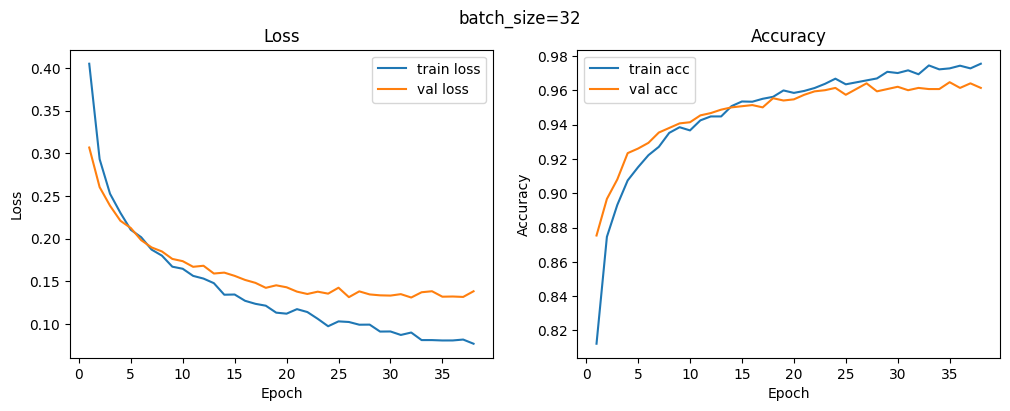


Training with batch_size = 64
Epoch 1/50
110/110 - 1s - 8ms/step - accuracy: 0.7899 - loss: 0.4452 - val_accuracy: 0.8460 - val_loss: 0.3445
Epoch 2/50
110/110 - 0s - 2ms/step - accuracy: 0.8587 - loss: 0.3229 - val_accuracy: 0.8780 - val_loss: 0.2872
Epoch 3/50
110/110 - 0s - 2ms/step - accuracy: 0.8806 - loss: 0.2798 - val_accuracy: 0.8933 - val_loss: 0.2582
Epoch 4/50
110/110 - 0s - 2ms/step - accuracy: 0.8930 - loss: 0.2515 - val_accuracy: 0.9073 - val_loss: 0.2396
Epoch 5/50
110/110 - 0s - 2ms/step - accuracy: 0.9050 - loss: 0.2300 - val_accuracy: 0.9173 - val_loss: 0.2263
Epoch 6/50
110/110 - 0s - 2ms/step - accuracy: 0.9134 - loss: 0.2178 - val_accuracy: 0.9233 - val_loss: 0.2198
Epoch 7/50
110/110 - 0s - 2ms/step - accuracy: 0.9180 - loss: 0.2050 - val_accuracy: 0.9307 - val_loss: 0.2114
Epoch 8/50
110/110 - 0s - 2ms/step - accuracy: 0.9234 - loss: 0.2020 - val_accuracy: 0.9327 - val_loss: 0.2044
Epoch 9/50
110/110 - 0s - 2ms/step - accuracy: 0.9244 - loss: 0.1912 - val_accura

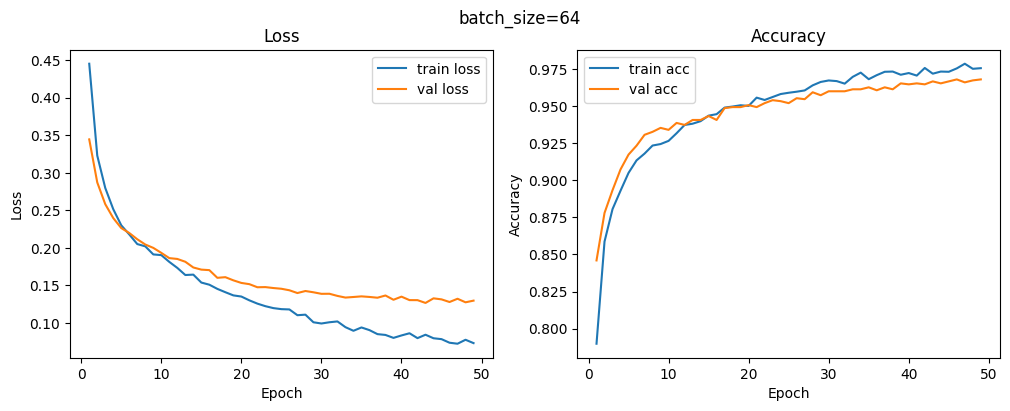


Training with batch_size = 128
Epoch 1/50
55/55 - 1s - 16ms/step - accuracy: 0.7353 - loss: 0.5272 - val_accuracy: 0.8260 - val_loss: 0.3942
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.8313 - loss: 0.3682 - val_accuracy: 0.8633 - val_loss: 0.3237
Epoch 3/50
55/55 - 0s - 3ms/step - accuracy: 0.8630 - loss: 0.3125 - val_accuracy: 0.8793 - val_loss: 0.2869
Epoch 4/50
55/55 - 0s - 3ms/step - accuracy: 0.8777 - loss: 0.2855 - val_accuracy: 0.8947 - val_loss: 0.2615
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.8873 - loss: 0.2598 - val_accuracy: 0.9040 - val_loss: 0.2446
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.9024 - loss: 0.2430 - val_accuracy: 0.9087 - val_loss: 0.2322
Epoch 7/50
55/55 - 0s - 3ms/step - accuracy: 0.9061 - loss: 0.2299 - val_accuracy: 0.9160 - val_loss: 0.2230
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9126 - loss: 0.2233 - val_accuracy: 0.9207 - val_loss: 0.2182
Epoch 9/50
55/55 - 0s - 2ms/step - accuracy: 0.9171 - loss: 0.2074 - val_accuracy: 0.9227 - val

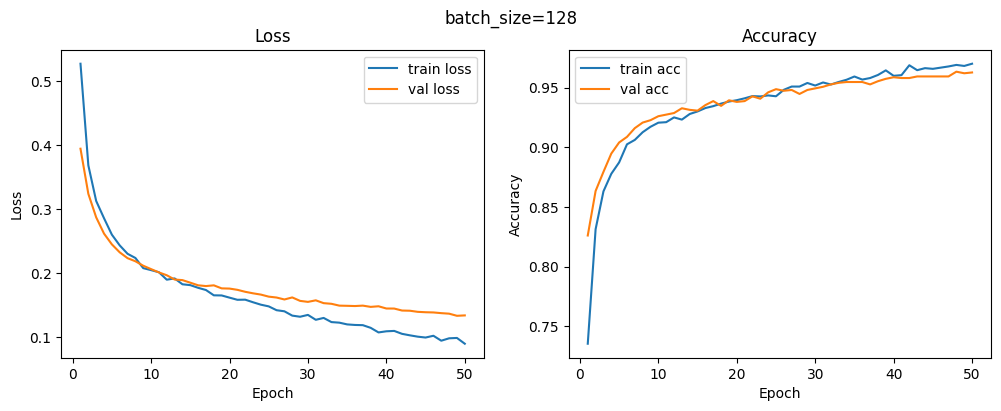

In [17]:
batch_options = [32, 64, 128]

for b in batch_options:
    print("\nTraining with batch_size =", b)

    model = build_mlp(
        input_shape=X_train.shape[1],
        layer_units=best_layer_units,
        dropout_rate=best_dropout,
        lr=best_lr
    )

    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6,
        restore_best_weights=True, verbose=1
    )

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=b,
        callbacks=[es],
        verbose=2
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", test_loss, "Test Acc:", test_acc)

    plot_history(hist, title=f"batch_size={b}")


Batch size 64 also looks good, but batch size 128 is better overall.

It has lower validation loss, higher or equal validation accuracy,
and much smoother, more stable training curves.

Batch 64 shows more noise and slightly worse generalization.

 Therefore, batch_size=128 is the best choice.


In [18]:
best_batch = 128

# 7. Final Training with all chosen hyperparameters

In [ ]:
print("Training final model with:")
print("layers =", best_layer_units)
print("dropout =", best_dropout)
print("lr =", best_lr)
print("batch =", best_batch)

model = build_mlp(
    input_shape=X_train.shape[1],
    layer_units=best_layer_units,
    dropout_rate=best_dropout,
    lr=best_lr
)

es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10,
    restore_best_weights=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=best_batch,
    callbacks=[es],
    verbose=2
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("\nFinal Test Loss:", test_loss)
print("Final Test Acc:", test_acc)

plot_history(history, title="Final Model Training")


Training final model with:
layers = (128, 64)
dropout = 0.25
lr = 0.001
batch = 128
Epoch 1/200
55/55 - 1s - 17ms/step - accuracy: 0.7266 - loss: 0.5252 - val_accuracy: 0.8253 - val_loss: 0.3975
Epoch 2/200
55/55 - 0s - 3ms/step - accuracy: 0.8364 - loss: 0.3602 - val_accuracy: 0.8620 - val_loss: 0.3240
Epoch 3/200
55/55 - 0s - 3ms/step - accuracy: 0.8680 - loss: 0.3101 - val_accuracy: 0.8827 - val_loss: 0.2874
Epoch 4/200
55/55 - 0s - 3ms/step - accuracy: 0.8781 - loss: 0.2796 - val_accuracy: 0.8967 - val_loss: 0.2623
Epoch 5/200
55/55 - 0s - 3ms/step - accuracy: 0.8911 - loss: 0.2580 - val_accuracy: 0.9073 - val_loss: 0.2437
Epoch 6/200
55/55 - 0s - 3ms/step - accuracy: 0.9033 - loss: 0.2409 - val_accuracy: 0.9193 - val_loss: 0.2322
Epoch 7/200
55/55 - 0s - 3ms/step - accuracy: 0.9114 - loss: 0.2289 - val_accuracy: 0.9207 - val_loss: 0.2213
Epoch 8/200
55/55 - 0s - 3ms/step - accuracy: 0.9134 - loss: 0.2164 - val_accuracy: 0.9233 - val_loss: 0.2129
Epoch 9/200
55/55 - 0s - 3ms/step -

## 8. Tips & next steps


* If validation curves show **overfitting** (train loss much lower than val loss): increase dropout, add L2 regularization, or gather more data.

* If model **underfits** (both losses high, accuracy low): increase model capacity (more units/layers), train longer (more epochs), or reduce regularization.
